In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy import stats

/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Import data

In [3]:
df = pd.read_csv("./data/boston.csv")

Input features in order:
1) CRIM: per capita crime rate by town
2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3) INDUS: proportion of non-retail business acres per town
4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]
6) RM: average number of rooms per dwelling
7) AGE: proportion of owner-occupied units built prior to 1940
8) DIS: weighted distances to five Boston employment centres
9) RAD: index of accessibility to radial highways
10) TAX: full-value property-tax rate per $10,000 [$/10k]
11) PTRATIO: pupil-teacher ratio by town
12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13) LSTAT: % lower status of the population

Output variable:
1) MEDV: Median value of owner-occupied homes in $1000's [k$]



In [4]:
# get familiar with the data, check the shape, the first 5 rows, df.describe(), df.info()

df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,534.000000,533.000000,534.000000,534.000000,532.000000,531.000000,533.000000,531.000000,531.000000,533.000000,533.000000,531.000000,533.000000,533.000000
mean,3.710890,10.960600,11.190187,0.067416,0.555249,6.276755,68.982176,3.769165,9.766478,410.801126,18.483114,356.759435,12.767280,697.230582
std,8.636097,22.852036,6.813075,0.250976,0.115924,0.703093,28.008780,2.093166,8.803199,169.406011,2.143362,91.114487,7.141796,11031.536340
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,-27.100000
25%,0.082757,0.000000,5.190000,0.000000,0.449000,5.888000,45.600000,2.075400,4.000000,280.000000,17.400000,375.270000,7.180000,16.500000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.216000,77.300000,3.182700,5.000000,330.000000,19.100000,391.340000,11.500000,21.000000
75%,3.846485,12.500000,18.100000,0.000000,0.631000,6.605000,94.300000,5.116700,24.000000,666.000000,20.200000,396.235000,17.110000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,190000.500000


<AxesSubplot:>

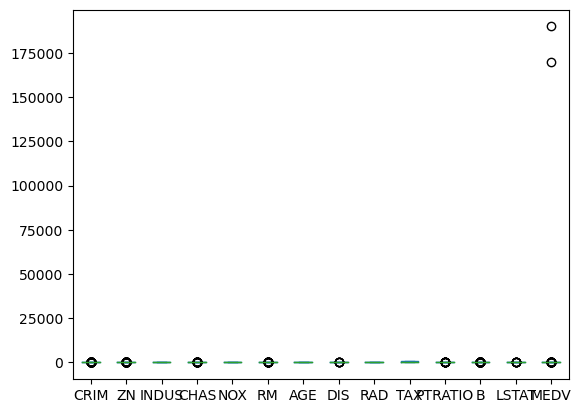

In [5]:
df.plot.box()

# Data cleaning

## Remove NaN values

In [6]:
df.dropna(inplace=True)

In [7]:
df = df.query('MEDV >= 0')


# Handle outliers

In [8]:
# Did you notice anything weird in df.describe()? If not, check out MEDV's max value, the min value and the mean value. 
# What's going on? Is this a problem? How can you fix it?
z_scores = stats.zscore(df["MEDV"])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
df = df[filtered_entries]

<AxesSubplot:>

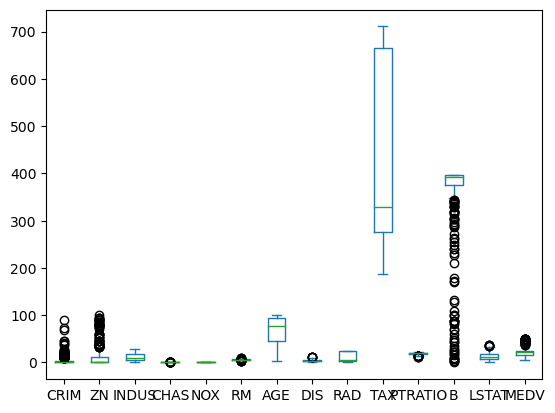

In [9]:
df.plot.box()

## Remove duplicates

In [10]:
# HINT: there is a function in pandas made just for this purpose
# HINT 2: https://google.gprivate.com/search.php?search?q=pandas+remove+duplicates

df.drop_duplicates(inplace = True)

df.duplicated().value_counts()

False    480
dtype: int64

# Model creation

In [11]:
# Create the XGBoost regression model. XGBoost stands for: eXtreme Gradient Boosting. 
# This is a very popular algorithm, used in machine learning competitions and in the industry. 
# We will use it for regression, but it can also be used for classification.

model = xgb.XGBRegressor()

In [12]:
# let y be the target column, and X be the rest of the df
df2 = df.drop(['MEDV'], axis=1)

X = df2
y = df["MEDV"]

In [13]:
df2

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
530,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
531,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
532,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [14]:
# Split the data into train and test sets with the function train_test_split from sklearn. Use test_size=0.2 and random_state=42
# We use train_test_split to split the data into train and test sets. We will use the train set to train the model, and the test set to evaluate the model.
# The reason we need a test set is to be able to evaluate the model. If we train the model on the whole dataset, 
# it will learn the dataset perfectly, but we will not know how it performs on unseen data. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# use the training set (X_train, y_train) to train the model by calling the .fit() method
model.fit(X_train, y_train)

/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [16]:
# Use the model to predict the target values for the test set (X_test)
preds = model.predict(X_test)

In [17]:
# find the mean squared error for the predictions (a value to see the value of the predictions, lower is better)
# find the error between the y_test and the preds
mse = mean_squared_error(y_test, preds)

In [18]:
# print the mse to see how much, on average, your model is off (squared)
mse

10.68097416865667

# Hyperparameter tuning

In [19]:
# These are some of the hyperparameters you can tune for XGBoost. 
# A hyperparameter is a parameter that is not learned by the model, but is set by the user.
# The parameters that are learned by the model are called model parameters.
# The model starts off with some default values for the hyperparameters, but you can change them to get potentially better results.
# This process is called hyperparameter tuning.

# If you want, you can adjust the hyperparameters and see if you can get a better result. You can also add more hyperparameters to the dictionary.
# List of hyperparameters: https://xgboost.readthedocs.io/en/latest/parameter.html
params = {
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
    "n_estimators": [100, 200, 300, 400, 500, 900, 1100, 1500],
}

In [21]:
# Use RandomizedSearchCV to find the best hyperparameters for the model. There are other ways to do this, but random search will work for this purpose.
# Random search is a method for hyperparameter tuning that will try a given number of random combinations of hyperparameters.
# Use the training set (X_train, y_train) to instantiate the random search by calling the .fit() method with the test set
# HINT: n_iter is the number of iterations to run the random search, if this number is too high, it will take a long time to run, 
# but if it's too low, it will not find the best hyperparameters. You should try to find a happy medium.

# First, create a new, similar model, but with the default hyperparameters. Do not fit this model with the training set.
model2 = xgb.XGBRegressor()

random_search = RandomizedSearchCV(model2, param_distributions=params, n_iter=20, scoring="neg_mean_squared_error", n_jobs=-1, cv=5)

# Fit the model with x and y train sets
random_search.fit(X_train, y_train)

/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed fr

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 900, 1100,
                                                         1500]},
                   scoring='neg_mean_squared_error')

In [119]:
# Retrieve the best model/estimator from the random search
model_new = random_search.best_estimator_

In [120]:
# Create new predictions with the new model
preds = model_new.predict(X_test)

In [121]:
# Get the new mean square error
mse_new = mean_squared_error(y_test, preds)

mse_new

9.934821029570136

In [122]:
print(f"relation between better error on the new model and the old error: {(mse_new / mse)}")

# If the new model did not perform better, this means that the default hyperparameters were better, but it is highly likely that even better ones exist.
# You can try to run the random search again, but with more iterations, or you can try to use GridSearchCV instead of RandomizedSearchCV ot test _every_ combination of hyperparameters.
# You can also edit the hyperparameters in the dictionary to see if you can get better results.

relation between better error on the new model and the old error: 0.9301418459304844
